In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [79]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Importing Necessary Libraries

In [80]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.3
tensorflow_hub version :  0.8.0


In [81]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [82]:
import tensorflow.contrib.eager as tfe
#tfe.enable_eager_execution()

## Setting The Output Directory

While fine-tuning the model, we will save the training checkpoints and the model in an output directory so that we can use the trained model for our predictions later.

In [83]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model_pooled_concat_sequence_norelabel_2_layer_ms0'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: model_pooled_concat_sequence_norelabel_2_layer_ms0 *****


## Loading The Data

In [84]:
stock='GM'
year='2020'

In [85]:
data=pd.read_csv('noneed_relabel.csv',index_col=0)
data

,text,search_term,label0,label1,label2
4,Tesla and Microsoft topped Wall Street earning...,MSFT,1,1.0,1.0
11,Microsoft ex-employee says contractors in Chin...,Microsoft,1,-1.0,-1.0
13,"Stocks making the biggest moves midday: Tesla,...",Microsoft,1,1.0,1.0
17,Microsoft says it aims to remove more carbon f...,Microsoft,1,0.5,1.0
19,"Salesforce, which once tried to buy LinkedIn, ...",Microsoft,1,0.0,0.0
...,...,...,...,...,...
10035,"Walmart to hire 50,000 more workers in coronav...",Walmart,1,1.0,1.0
10046,"Public health officials in Aurora, Colorado, o...",Walmart,1,-1.0,-1.0
10049,"Walmart is hiring 50,000 new workers, after hi...",Walmart,1,1.0,1.0
10050,"Vitalina Williams, 59, died of coronavirus on ...",Walmart,1,-1.0,-1.0


In [86]:
data['label2'].value_counts()

 1.0    673
-1.0    553
 0.0    515
-0.5    278
 0.5    260
-1.5     25
-2.0     24
 1.5     18
Name: label2, dtype: int64

In [87]:
for i in range(len(data)):
    if data.iloc[i,4]>0:
        data.iloc[i,4]=1
    elif data.iloc[i,4]==0:
        data.iloc[i,4]=0
    else:
        data.iloc[i,4]=-1
data

,text,search_term,label0,label1,label2
4,Tesla and Microsoft topped Wall Street earning...,MSFT,1,1.0,1.0
11,Microsoft ex-employee says contractors in Chin...,Microsoft,1,-1.0,-1.0
13,"Stocks making the biggest moves midday: Tesla,...",Microsoft,1,1.0,1.0
17,Microsoft says it aims to remove more carbon f...,Microsoft,1,0.5,1.0
19,"Salesforce, which once tried to buy LinkedIn, ...",Microsoft,1,0.0,0.0
...,...,...,...,...,...
10035,"Walmart to hire 50,000 more workers in coronav...",Walmart,1,1.0,1.0
10046,"Public health officials in Aurora, Colorado, o...",Walmart,1,-1.0,-1.0
10049,"Walmart is hiring 50,000 new workers, after hi...",Walmart,1,1.0,1.0
10050,"Vitalina Williams, 59, died of coronavirus on ...",Walmart,1,-1.0,-1.0


In [88]:
data['label2'].value_counts()

 1.0    951
-1.0    880
 0.0    515
Name: label2, dtype: int64

In [89]:
data_flag=data['label2']
data_feature=data
data_feature.drop('label2', axis = 1, inplace = True)

In [90]:
ind=[]
data_pred=pd.read_csv(stock+'_stock_sum/'+stock+'_stock_news_'+year+'.csv')
data_pred_time=data_pred.iloc[:,[2,-1,3,5]]
data_pred=data_pred.iloc[:,[2,-1,3]]

data_pred.columns=['text','search_term','label0']
data_pred.drop(index=(data_pred[data_pred.text=='text'].index),inplace=True)
data_pred_time.drop(index=(data_pred_time[data_pred_time.text=='text'].index),inplace=True)
data_pred

,text,search_term,label0
0,The MLB is suspending the Houston Astros’ GM a...,GM,4
1,The MLB is suspending the Houston Astros’ GM a...,GM,3
2,India is becoming one of the largest automotiv...,GM,12
3,GM buys Super Bowl air time to resurrect an al...,GM,31
4,LISTEN NOW: Twitter is testing a new filter fo...,GM,1
...,...,...,...
436,That’s not a reality. Most stores went busy on...,GM,0
437,General Motors announced earlier today it is s...,General Motor,12
438,Michigan’s attorney general said Wednesday tha...,General Motor,100
439,Kelly Willis Rice had just moved to the Kokomo...,General Motor,49


In [91]:
index=[]
for i in range(len(data_pred)):
    index.append(i)

In [92]:
data_pred_time.index=index
data_pred_time.to_csv(stock+'_stock_sum/'+stock+'tweets_include_time'+year+'.csv')

In [93]:
data_pred.index=index
for i in range(len(data_pred)):
    data_pred.iloc[i,-1]=0
    data_pred.iloc[i,0]=data_pred.iloc[i,0].split('http')[0]
data_pred

,text,search_term,label0
0,The MLB is suspending the Houston Astros’ GM a...,GM,0
1,The MLB is suspending the Houston Astros’ GM a...,GM,0
2,India is becoming one of the largest automotiv...,GM,0
3,GM buys Super Bowl air time to resurrect an al...,GM,0
4,LISTEN NOW: Twitter is testing a new filter fo...,GM,0
...,...,...,...
428,That’s not a reality. Most stores went busy on...,GM,0
429,General Motors announced earlier today it is s...,General Motor,0
430,Michigan’s attorney general said Wednesday tha...,General Motor,0
431,Kelly Willis Rice had just moved to the Kokomo...,General Motor,0


In [94]:
data_pred_flag=data_pred['label0']
data_pred_feature=data_pred
data_pred_feature.drop('label0', axis = 1, inplace = True)

## split dataset to train test and val

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val=train_test_split(data_feature,data_flag,test_size=0.3,random_state=42)
print(X_train.shape)
print(X_test_val.shape)
print(y_train.shape)
print(y_test_val.shape)

(1642, 4)
(704, 4)
(1642,)
(704,)


In [96]:
X_test, X_val, y_test, y_val=train_test_split(X_test_val,y_test_val,test_size=0.33,random_state=42)
print(X_test.shape)
print(X_val.shape)
print(y_test.shape)
print(y_val.shape)

(471, 4)
(233, 4)
(471,)
(233,)


In [97]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(1642, 4)
(1642,)
(471, 4)
(471,)
(233, 4)
(233,)


In [98]:
X_pred=data_pred_feature
y_pred=data_pred_flag

In [99]:
y_train.value_counts()

 1.0    643
-1.0    631
 0.0    368
Name: label2, dtype: int64

In [100]:
search_term=list(X_train['search_term'])
len(search_term)

1642

In [101]:
X_train['label0']=X_train['search_term']
X_train['search_term']=y_train
X_train

/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,search_term,label0,label1
7353,As governments race to roll out pandemic-fight...,1.0,Apple,1.0
3301,Halliburton takes $2.2 billion charge on shale...,-1.0,Halliburton,-1.0
8282,Facebook sues Bangkok resident for selling fra...,0.0,Facebook,0.0
3653,IBM chief calls for 'precision regulation' on ...,0.0,IBM,0.0
5412,Facebook announced that it would dole out $25 ...,1.0,Facebook,1.0
...,...,...,...,...
6687,Walmart to pay nearly $550 million in staff bo...,1.0,Walmart,1.0
4045,Our first question comes from Jack O'Shea who'...,0.0,Disney,0.0
4176,Disney's Bob Chapek sees other reasons the sto...,-1.0,Disney,-1.0
4843,The crash in Ethiopia was the 2nd time in 5 mo...,-1.0,Boeing,-1.0


In [102]:
X_train['search_term'].value_counts()

 1.0    643
-1.0    631
 0.0    368
Name: search_term, dtype: int64

In [103]:
X_test['label0']=X_test['search_term']
X_test['search_term']=y_test
X_val['label0']=X_val['search_term']
X_val['search_term']=y_val

/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [104]:
X_pred['label0']=X_pred['search_term']
X_pred['search_term']=y_pred

In [105]:
train=X_train
val=X_val
test=X_test

In [106]:
pred=X_pred

In [107]:
train.columns=['clean tweet','target','search_term','label1']
val.columns=['clean tweet','target','search_term','label1']
test.columns=['clean tweet','target','search_term','label1']

In [108]:
pred

,text,search_term,label0
0,The MLB is suspending the Houston Astros’ GM a...,0,GM
1,The MLB is suspending the Houston Astros’ GM a...,0,GM
2,India is becoming one of the largest automotiv...,0,GM
3,GM buys Super Bowl air time to resurrect an al...,0,GM
4,LISTEN NOW: Twitter is testing a new filter fo...,0,GM
...,...,...,...
428,That’s not a reality. Most stores went busy on...,0,GM
429,General Motors announced earlier today it is s...,0,General Motor
430,Michigan’s attorney general said Wednesday tha...,0,General Motor
431,Kelly Willis Rice had just moved to the Kokomo...,0,General Motor


In [109]:
pred.columns=['clean tweet','target','search_term']

In [110]:
train

,clean tweet,target,search_term,label1
7353,As governments race to roll out pandemic-fight...,1.0,Apple,1.0
3301,Halliburton takes $2.2 billion charge on shale...,-1.0,Halliburton,-1.0
8282,Facebook sues Bangkok resident for selling fra...,0.0,Facebook,0.0
3653,IBM chief calls for 'precision regulation' on ...,0.0,IBM,0.0
5412,Facebook announced that it would dole out $25 ...,1.0,Facebook,1.0
...,...,...,...,...
6687,Walmart to pay nearly $550 million in staff bo...,1.0,Walmart,1.0
4045,Our first question comes from Jack O'Shea who'...,0.0,Disney,0.0
4176,Disney's Bob Chapek sees other reasons the sto...,-1.0,Disney,-1.0
4843,The crash in Ethiopia was the 2nd time in 5 mo...,-1.0,Boeing,-1.0


In [111]:
train['target'].value_counts()

 1.0    643
-1.0    631
 0.0    368
Name: target, dtype: int64

In [112]:
max_value=0
for i in train['target'].value_counts():
    if i>max_value:
        max_value=i
max_value

643

In [113]:
train_0_down=train[train['target']==0].index
train_0_down

Int64Index([8282, 3653, 4074, 9167, 3156, 9232, 4078, 2562, 2637, 2094,
            ...
            8674, 8698, 1956, 8632, 2576, 9975, 1640, 9166, 4045, 3032],
           dtype='int64', length=368)

In [114]:
train_1_down=train[train['target']==1].index
train_1_down

Int64Index([7353, 5412,  240, 8659, 2036, 7873, 7624, 1560, 5872, 1815,
            ...
            6141, 7866, 7543, 1654,  116, 1622, 6884,  498, 1158, 6687],
           dtype='int64', length=643)

In [115]:
train_m1_down=train[train['target']==-1].index
train_m1_down

Int64Index([3301, 5032, 4136, 4362, 1050, 4822, 2510, 2522, 1428,  182,
            ...
            4350, 3390, 4499, 6070, 2656, 9070, 5798, 4670, 4176, 4843],
           dtype='int64', length=631)

In [116]:
import random
slice1 = random.sample(list(train_0_down), max_value-len(train_0_down))
slice2 = random.sample(list(train_1_down), max_value-len(train_1_down))
slice3 = random.sample(list(train_m1_down), max_value-len(train_m1_down))
slice4=slice1+slice2+slice3

In [117]:
for i in slice4:
    df=train[train.index==i]
    df.index=df.index+15000
    train=pd.concat([train,df])

In [118]:
train['target'].value_counts()

 0.0    643
-1.0    643
 1.0    643
Name: target, dtype: int64

In [119]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

Training Set Shape : (1929, 4)
Validation Set Shape : (233, 4)
Test Set Shape : (471, 4)


In [120]:
#unique classes
train['target'].unique()

array([ 1., -1.,  0.])

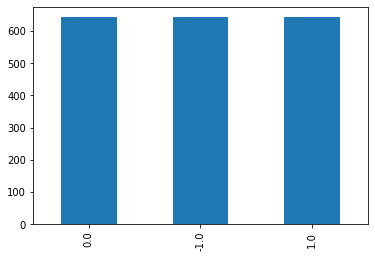

In [121]:
#Distribution of classes
train['target'].value_counts().plot(kind = 'bar')

In [122]:
DATA_COLUMN = 'clean tweet'
LABEL_COLUMN = 'target'
# The list containing all the classes (train['SECTION'].unique())
label_list = [-1,0, 1]

In [123]:
redeal=['ZM','XOM','Walmart','Virgin Galactic','United Airlines','USO','Spirit Airlines','Southwest Airlines',
 'SIRI','Royal Caribbean','ROKU','Pfizer','Occidental Petroleum','Norwegian Cruise Line','New Residential','Moderna','Marathon Oil',
 'Luckin Coffee','LYFT','LUV','LK','JetBlue','JPM','Halliburton','Groupon','GoPro','Gilead Sciences','Fitbit','Exxon Mobil',
 'Energy Transfer','Delta Air Lines','Coca-Cola','Canopy Growth','CCL','Beyond Meat','Berkshire Hathaway','Bank of America','BYND',
 'Aurora Cannabis','American Airlines','Alibaba','AMD','DIS']

In [124]:
for i in range(len(train)):
    if train.iloc[i,2] in redeal:
        cleaning=train.iloc[i,0].lower()
        cleaning2=train.iloc[i,2].lower()
        tweets=cleaning.replace(cleaning2,'presentation')
        train.iloc[i,0]=tweets
        train.iloc[i,2]='presentation'
train

,clean tweet,target,search_term,label1
7353,As governments race to roll out pandemic-fight...,1.0,Apple,1.0
3301,presentation takes $2.2 billion charge on shal...,-1.0,presentation,-1.0
8282,Facebook sues Bangkok resident for selling fra...,0.0,Facebook,0.0
3653,IBM chief calls for 'precision regulation' on ...,0.0,IBM,0.0
5412,Facebook announced that it would dole out $25 ...,1.0,Facebook,1.0
...,...,...,...,...
15947,Boeing swings to loss amid 737 Max crisis,-1.0,Boeing,-1.0
17436,presentation airways is hiking its checked bag...,-1.0,presentation,-1.0
16138,Boeing puts cost of 737 Max crashes at $19bn a...,-1.0,Boeing,-1.0
19676,Coronavirus: BA chief executive hints at job c...,-1.0,BA,-1.0


In [125]:
for i in range(len(val)):
    if val.iloc[i,2] in redeal:
        cleaning=val.iloc[i,0].lower()
        cleaning2=val.iloc[i,2].lower()
        tweets=cleaning.replace(cleaning2,'presentation')
        val.iloc[i,0]=tweets
        val.iloc[i,2]='presentation'
val

/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,clean tweet,target,search_term,label1
3665,"S&P 500, Nasdaq hit record highs on IBM, chip ...",1.0,IBM,1.0
3094,Netflix has changed the way people watch TV an...,1.0,Netflix,0.5
2073,Wall Street analysts say invest in these top s...,1.0,Facebook,1.0
9010,One key level in Netflix should prove support ...,0.0,NFLX,0.0
4276,"presentation says bookings still falling, work...",-1.0,presentation,-1.0
...,...,...,...,...
4996,"about six years ago, presentation was bleeding...",1.0,presentation,1.0
7139,presentation slashes flights but has no plans ...,-1.0,presentation,-1.0
9896,"It's used for work, school, Friday-night drink...",1.0,Zoom,1.0
2953,Has Netflix quietly cancelled Mindhunter?,0.0,Netflix,0.0


In [126]:
for i in range(len(test)):
    if test.iloc[i,2] in redeal:
        cleaning=test.iloc[i,0].lower()
        cleaning2=test.iloc[i,2].lower()
        tweets=cleaning.replace(cleaning2,'presentation')
        test.iloc[i,0]=tweets
        test.iloc[i,2]='presentation'
test

/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,clean tweet,target,search_term,label1
7534,"Snap soars on strong growth in revenue, daily ...",1.0,SNAP,1.0
508,Apple's incredible wearables: AirPods and Watc...,1.0,Apple,1.0
7056,Disney chairman Bob Iger praised for forgoing ...,1.0,Disney,1.0
5002,Tesla and Elon Musk may have started an EV rev...,0.0,Tesla,0.0
4326,Carnival Princess Cruises operations are being...,-1.0,Carnival,-1.0
...,...,...,...,...
5134,Facebook Messenger could ban mass forwarding o...,0.0,Facebook,0.0
3025,Netflix paints a happy face on growing threat ...,1.0,Netflix,1.0
9719,Teachers have been stopped from using Zoom in ...,-1.0,Zoom,-1.0
2778,If hackers could get into Amazon CEO Jeff Bezo...,-1.0,Amazon,-1.0


In [127]:
for i in range(len(pred)):
    if pred.iloc[i,2] in redeal:
        cleaning=pred.iloc[i,0].lower()
        cleaning2=pred.iloc[i,2].lower()
        tweets=cleaning.replace(cleaning2,'presentation')
        pred.iloc[i,0]=tweets
        pred.iloc[i,2]='presentation'
pred

,clean tweet,target,search_term
0,The MLB is suspending the Houston Astros’ GM a...,0,GM
1,The MLB is suspending the Houston Astros’ GM a...,0,GM
2,India is becoming one of the largest automotiv...,0,GM
3,GM buys Super Bowl air time to resurrect an al...,0,GM
4,LISTEN NOW: Twitter is testing a new filter fo...,0,GM
...,...,...,...
428,That’s not a reality. Most stores went busy on...,0,GM
429,General Motors announced earlier today it is s...,0,General Motor
430,Michigan’s attorney general said Wednesday tha...,0,General Motor
431,Kelly Willis Rice had just moved to the Kokomo...,0,General Motor


## Data Preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have the following four features:

* guid : A unique id that represents an observation.
* text_a : The text we need to classify into given categories
* text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.
* label: It consists of the labels or classes or categories that a given text belongs to.
 
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.


In [128]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [129]:
test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [130]:
pred_InputExamples = pred.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [131]:
print("### Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n### Row 0 - text_a of training set : \n", train_InputExamples.iloc[0].text_a)
print("\n### Row 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n### Row 0 - label of training set : ", train_InputExamples.iloc[0].label)

### Row 0 - guid of training set :  None

### Row 0 - text_a of training set : 
 As governments race to roll out pandemic-fighting contact-tracing apps, including an Apple-Google effort in the U.S., Singapore’s early experiment has hit a hurdle 

### Row 0 - text_b of training set :  None

### Row 0 - label of training set :  1.0


## Tokenizing Texts

We will now get down to business with the pretrained BERT.  In this example we will use the ```bert_uncased_L-12_H-768_A-12/1``` model. To check all available versions click [here](https://tfhub.dev/s?network-architecture=transformer&publisher=google).

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

---

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.


In [132]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
        
    # !!! this is time-consuming as the model is giant !!!
    bert_module = hub.Module(BERT_MODEL_HUB) # second time is fast as the module is cached
    
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [133]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['as', 'governments', 'race', 'to', 'roll', 'out', 'pan', '##de', '##mic', '-', 'fighting', 'contact', '-', 'tracing', 'apps', ',', 'including', 'an', 'apple', '-', 'google', 'effort', 'in', 'the', 'u', '.', 's', '.', ',', 'singapore', '’', 's', 'early', 'experiment', 'has', 'hit', 'a', 'hurdle']


In [134]:
train_part=train
train_part

,clean tweet,target,search_term,label1
7353,As governments race to roll out pandemic-fight...,1.0,Apple,1.0
3301,presentation takes $2.2 billion charge on shal...,-1.0,presentation,-1.0
8282,Facebook sues Bangkok resident for selling fra...,0.0,Facebook,0.0
3653,IBM chief calls for 'precision regulation' on ...,0.0,IBM,0.0
5412,Facebook announced that it would dole out $25 ...,1.0,Facebook,1.0
...,...,...,...,...
15947,Boeing swings to loss amid 737 Max crisis,-1.0,Boeing,-1.0
17436,presentation airways is hiking its checked bag...,-1.0,presentation,-1.0
16138,Boeing puts cost of 737 Max crashes at $19bn a...,-1.0,Boeing,-1.0
19676,Coronavirus: BA chief executive hints at job c...,-1.0,BA,-1.0


In [135]:
val_part=val
val_part

,clean tweet,target,search_term,label1
3665,"S&P 500, Nasdaq hit record highs on IBM, chip ...",1.0,IBM,1.0
3094,Netflix has changed the way people watch TV an...,1.0,Netflix,0.5
2073,Wall Street analysts say invest in these top s...,1.0,Facebook,1.0
9010,One key level in Netflix should prove support ...,0.0,NFLX,0.0
4276,"presentation says bookings still falling, work...",-1.0,presentation,-1.0
...,...,...,...,...
4996,"about six years ago, presentation was bleeding...",1.0,presentation,1.0
7139,presentation slashes flights but has no plans ...,-1.0,presentation,-1.0
9896,"It's used for work, school, Friday-night drink...",1.0,Zoom,1.0
2953,Has Netflix quietly cancelled Mindhunter?,0.0,Netflix,0.0


In [136]:
test_part=test
test_part

,clean tweet,target,search_term,label1
7534,"Snap soars on strong growth in revenue, daily ...",1.0,SNAP,1.0
508,Apple's incredible wearables: AirPods and Watc...,1.0,Apple,1.0
7056,Disney chairman Bob Iger praised for forgoing ...,1.0,Disney,1.0
5002,Tesla and Elon Musk may have started an EV rev...,0.0,Tesla,0.0
4326,Carnival Princess Cruises operations are being...,-1.0,Carnival,-1.0
...,...,...,...,...
5134,Facebook Messenger could ban mass forwarding o...,0.0,Facebook,0.0
3025,Netflix paints a happy face on growing threat ...,1.0,Netflix,1.0
9719,Teachers have been stopped from using Zoom in ...,-1.0,Zoom,-1.0
2778,If hackers could get into Amazon CEO Jeff Bezo...,-1.0,Amazon,-1.0


In [137]:
pred_part=pred
pred_part

,clean tweet,target,search_term
0,The MLB is suspending the Houston Astros’ GM a...,0,GM
1,The MLB is suspending the Houston Astros’ GM a...,0,GM
2,India is becoming one of the largest automotiv...,0,GM
3,GM buys Super Bowl air time to resurrect an al...,0,GM
4,LISTEN NOW: Twitter is testing a new filter fo...,0,GM
...,...,...,...
428,That’s not a reality. Most stores went busy on...,0,GM
429,General Motors announced earlier today it is s...,0,General Motor
430,Michigan’s attorney general said Wednesday tha...,0,General Motor
431,Kelly Willis Rice had just moved to the Kokomo...,0,General Motor


In [138]:
search_dict={'msft':'microsoft','ford':'ford','ge':'general electric','dis':'disney','aal':'american airlines','dal':'delta air lines',\
               'gpro':'gopro','ccl':'carnival','aapl':'apple','fitbit':'fitbit','plug':'plug power','bac':'bank of america',\
               'snap':'snap','nclh':'norwegian cruise line','ba':'boeing','ino':'inovio','ual':'united airlines','cgc':\
                'canopy growth','uber':'uber','rcl':'royal caribbean','cron':'cronos group','amd':'amd','twtr':'twtr','tsla':\
               'tesla','grpn':'groupon','fb':'facebook','acb':'aurora cannabis','sbux':'starbucks','mro':'marathon oil','delta':'delta',\
                'znga':'zynga','baba':'alibaba','uso':'united states oil fund','ko':'coca-cola','apha':'aphria','dow':'dow',\
                'xom':'exxon mobil','mfa':'mfa','jblu':'jetblue','amzn':'amazon','luv':'southwest airlines','nio':'nio','mrna':'moderna',\
                'gm':'general motor','spirit airlines':'spirit Airlines','mgm':'mgm','gild':'gilead sciences','nflx':'netflix','nrz':'new residential','spce':\
                'virgin galactic','lk':'luckin coffee','vslr':'vivint solar','uco':'uco','voo':'vanguard','penn':'penn','amc':'amc','tlry':\
                'tilray','hal':'halliburton','nok':'nokia','lyft':'lyft','nvda':'nvidia','cprx':'catalyst pharmaceuticals','spy':\
                'spdr s&p 500 etf','nke':'nike','sq':'sq','visa':'visa','siri':'siri','brk.b':'berkshire hathaway','cpe':'callon petroleum',\
                'slack':'slack','gush':'gush','bynd':'beyond meat','pfe':'pfizer','oxy':'occidental petroleum','kos':'kos','mcd': 'mcdonald',\
                'energy transfer':'energy transfer','crbp':'corbus pharmaceuticals','sphd':'sphd','ntdoy':'nintendo','zm':'zoom','jpm':'jpm',\
                'vktx':'viking therapeutics','ibm':'ibm','nymt':'nymt','intc':'intel','wmt':'walmart','sne':'sony','roku':'roku','presentation':'presentation'}
search_dict

{'msft': 'microsoft',
 'ford': 'ford',
 'ge': 'general electric',
 'dis': 'disney',
 'aal': 'american airlines',
 'dal': 'delta air lines',
 'gpro': 'gopro',
 'ccl': 'carnival',
 'aapl': 'apple',
 'fitbit': 'fitbit',
 'plug': 'plug power',
 'bac': 'bank of america',
 'snap': 'snap',
 'nclh': 'norwegian cruise line',
 'ba': 'boeing',
 'ino': 'inovio',
 'ual': 'united airlines',
 'cgc': 'canopy growth',
 'uber': 'uber',
 'rcl': 'royal caribbean',
 'cron': 'cronos group',
 'amd': 'amd',
 'twtr': 'twtr',
 'tsla': 'tesla',
 'grpn': 'groupon',
 'fb': 'facebook',
 'acb': 'aurora cannabis',
 'sbux': 'starbucks',
 'mro': 'marathon oil',
 'delta': 'delta',
 'znga': 'zynga',
 'baba': 'alibaba',
 'uso': 'united states oil fund',
 'ko': 'coca-cola',
 'apha': 'aphria',
 'dow': 'dow',
 'xom': 'exxon mobil',
 'mfa': 'mfa',
 'jblu': 'jetblue',
 'amzn': 'amazon',
 'luv': 'southwest airlines',
 'nio': 'nio',
 'mrna': 'moderna',
 'gm': 'general motor',
 'spirit airlines': 'spirit Airlines',
 'mgm': 'mgm',

In [139]:
len(train_InputExamples)

1929

In [140]:
binar=[]
nodrop_index=[]
errr=0
for i in range (len(train_InputExamples)):
    c=[]
    for j in tokenizer.tokenize(train_InputExamples.iloc[i].text_a):
        #print(j)
        search_1=train_part['search_term'].iloc[i]
        if search_1.lower() in search_dict.keys():
            search_2=search_dict[search_1.lower()]
        else:
            search_2=list(search_dict.keys())[list(search_dict.values()).index(search_1.lower())]
        if j == search_1.lower() or j == search_2:
            c.append(1)
        else:
            c.append(0)
    if search_1=='presentation':
        train_part['search_term'].iloc[i]='[MASK]'
        train_InputExamples.iloc[3].text_a=train_InputExamples.iloc[3].text_a.replace('presentation','[MASK]')
    if sum(c)!=0:
        nodrop_index.append(i)
        binar.append(c)

In [141]:
train_InputExamples=train_InputExamples.iloc[nodrop_index]

In [142]:
len(train_InputExamples)

1912

In [143]:
binar2=[]
for i in range (len(val_InputExamples)):
    c=[]
    for j in tokenizer.tokenize(val_InputExamples.iloc[i].text_a):
        search_1=val_part['search_term'].iloc[i]    
        if search_1.lower() in search_dict.keys():
            search_2=search_dict[search_1.lower()]
        else:
            search_2=list(search_dict.keys())[list(search_dict.values()).index(search_1.lower())]
        if j==search_1.lower() or j==search_2:
            c.append(1)
        else:
            c.append(0)
    if search_1=='presentation':
        val_part['search_term'].iloc[i]='[MASK]'
        val_InputExamples.iloc[3].text_a=val_InputExamples.iloc[3].text_a.replace('presentation','[MASK]')
    binar2.append(c)

In [144]:
binar3=[]
for i in range (len(test_InputExamples)):
    c=[]
    for j in tokenizer.tokenize(test_InputExamples.iloc[i].text_a):
        search_1=test_part['search_term'].iloc[i]    
        if search_1.lower() in search_dict.keys():
            search_2=search_dict[search_1.lower()]
        else:
            search_2=list(search_dict.keys())[list(search_dict.values()).index(search_1.lower())]
        if j==search_1.lower() or j==search_2:
            c.append(1)
        else:
            c.append(0)
    if search_1=='presentation':
        test_part['search_term'].iloc[i]='[MASK]'
        test_InputExamples.iloc[3].text_a=test_InputExamples.iloc[3].text_a.replace('presentation','[MASK]')
    binar3.append(c)

In [145]:
binar4=[]
for i in range (len(pred_InputExamples)):
    c=[]
    for j in tokenizer.tokenize(pred_InputExamples.iloc[i].text_a):
        search_1=pred_part['search_term'].iloc[i]    
        if search_1.lower() in search_dict.keys():
            search_2=search_dict[search_1.lower()]
        else:
            search_2=list(search_dict.keys())[list(search_dict.values()).index(search_1.lower())]
        if j==search_1.lower() or j==search_2:
            c.append(1)
        else:
            c.append(0)
    if search_1=='presentation':
        pred_part['search_term'].iloc[i]='[MASK]'
        pred_InputExamples.iloc[3].text_a=pred_InputExamples.iloc[3].text_a.replace('presentation','[MASK]')
    binar4.append(c)

In [146]:
import numpy as np
for i in binar:
     while len(i)<128:
        i.append(0)
binar=np.array(binar)

In [147]:
for i in binar2:
     while len(i)<128:
        i.append(0)
binar2=np.array(binar2)

In [148]:
for i in binar3:
     while len(i)<128:
        i.append(0)
binar3=np.array(binar3)

In [149]:
binar5=[]
for i in binar4:
    if len(i)>128:
        i=i[:128]  
        binar5.append(i)
    else:
        while len(i)<128:
            i.append(0)
        binar5.append(i)
binar5=np.array(binar5)

We will now format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

# Model Creation

In [150]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1912


INFO:tensorflow:Writing example 0 of 1912


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] as governments race to roll out pan ##de ##mic - fighting contact - tracing apps , including an apple - google effort in the u . s . , singapore ’ s early experiment has hit a hurdle [SEP]


INFO:tensorflow:tokens: [CLS] as governments race to roll out pan ##de ##mic - fighting contact - tracing apps , including an apple - google effort in the u . s . , singapore ’ s early experiment has hit a hurdle [SEP]


INFO:tensorflow:input_ids: 101 2004 6867 2679 2000 4897 2041 6090 3207 7712 1011 3554 3967 1011 16907 18726 1010 2164 2019 6207 1011 8224 3947 1999 1996 1057 1012 1055 1012 1010 5264 1521 1055 2220 7551 2038 2718 1037 27630 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2004 6867 2679 2000 4897 2041 6090 3207 7712 1011 3554 3967 1011 16907 18726 1010 2164 2019 6207 1011 8224 3947 1999 1996 1057 1012 1055 1012 1010 5264 1521 1055 2220 7551 2038 2718 1037 27630 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] presentation takes $ 2 . 2 billion charge on shale slump [SEP]


INFO:tensorflow:tokens: [CLS] presentation takes $ 2 . 2 billion charge on shale slump [SEP]


INFO:tensorflow:input_ids: 101 8312 3138 1002 1016 1012 1016 4551 3715 2006 18488 28702 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8312 3138 1002 1016 1012 1016 4551 3715 2006 18488 28702 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1.0 (id = 0)


INFO:tensorflow:label: -1.0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] facebook sue ##s bangkok resident for selling fraudulent ad tools [SEP]


INFO:tensorflow:tokens: [CLS] facebook sue ##s bangkok resident for selling fraudulent ad tools [SEP]


INFO:tensorflow:input_ids: 101 9130 9790 2015 12627 6319 2005 4855 27105 4748 5906 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9130 9790 2015 12627 6319 2005 4855 27105 4748 5906 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ibm chief calls for ' precision regulation ' on ai that weighs privacy against benefits to society [SEP]


INFO:tensorflow:tokens: [CLS] ibm chief calls for ' precision regulation ' on ai that weighs privacy against benefits to society [SEP]


INFO:tensorflow:input_ids: 101 9980 2708 4455 2005 1005 11718 7816 1005 2006 9932 2008 21094 9394 2114 6666 2000 2554 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9980 2708 4455 2005 1005 11718 7816 1005 2006 9932 2008 21094 9394 2114 6666 2000 2554 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] facebook announced that it would do ##le out $ 25 million in grants to local news outlets . it will also spend $ 75 million in a marketing drive aimed at news organizations internationally in response to the economic down ##turn prompted by the corona ##virus . [SEP]


INFO:tensorflow:tokens: [CLS] facebook announced that it would do ##le out $ 25 million in grants to local news outlets . it will also spend $ 75 million in a marketing drive aimed at news organizations internationally in response to the economic down ##turn prompted by the corona ##virus . [SEP]


INFO:tensorflow:input_ids: 101 9130 2623 2008 2009 2052 2079 2571 2041 1002 2423 2454 1999 8624 2000 2334 2739 11730 1012 2009 2097 2036 5247 1002 4293 2454 1999 1037 5821 3298 6461 2012 2739 4411 7587 1999 3433 2000 1996 3171 2091 22299 9469 2011 1996 21887 23350 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9130 2623 2008 2009 2052 2079 2571 2041 1002 2423 2454 1999 8624 2000 2334 2739 11730 1012 2009 2097 2036 5247 1002 4293 2454 1999 1037 5821 3298 6461 2012 2739 4411 7587 1999 3433 2000 1996 3171 2091 22299 9469 2011 1996 21887 23350 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:Writing example 0 of 233


INFO:tensorflow:Writing example 0 of 233


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] s & p 500 , nas ##da ##q hit record highs on ibm , chip power [SEP]


INFO:tensorflow:tokens: [CLS] s & p 500 , nas ##da ##q hit record highs on ibm , chip power [SEP]


INFO:tensorflow:input_ids: 101 1055 1004 1052 3156 1010 17235 2850 4160 2718 2501 26836 2006 9980 1010 9090 2373 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1055 1004 1052 3156 1010 17235 2850 4160 2718 2501 26836 2006 9980 1010 9090 2373 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] netflix has changed the way people watch tv and film but more competition is forcing it to look outside the us for growth [SEP]


INFO:tensorflow:tokens: [CLS] netflix has changed the way people watch tv and film but more competition is forcing it to look outside the us for growth [SEP]


INFO:tensorflow:input_ids: 101 20907 2038 2904 1996 2126 2111 3422 2694 1998 2143 2021 2062 2971 2003 6932 2009 2000 2298 2648 1996 2149 2005 3930 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 20907 2038 2904 1996 2126 2111 3422 2694 1998 2143 2021 2062 2971 2003 6932 2009 2000 2298 2648 1996 2149 2005 3930 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wall street analysts say invest in these top stocks in 2020 , including mcdonald ' s & facebook [SEP]


INFO:tensorflow:tokens: [CLS] wall street analysts say invest in these top stocks in 2020 , including mcdonald ' s & facebook [SEP]


INFO:tensorflow:input_ids: 101 2813 2395 18288 2360 15697 1999 2122 2327 15768 1999 12609 1010 2164 9383 1005 1055 1004 9130 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2813 2395 18288 2360 15697 1999 2122 2327 15768 1999 12609 1010 2164 9383 1005 1055 1004 9130 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] one key level in netflix should prove support in case of a pull ##back : trader $ nfl ##x ( via @ trading ##nation ) [SEP]


INFO:tensorflow:tokens: [CLS] one key level in netflix should prove support in case of a pull ##back : trader $ nfl ##x ( via @ trading ##nation ) [SEP]


INFO:tensorflow:input_ids: 101 2028 3145 2504 1999 20907 2323 6011 2490 1999 2553 1997 1037 4139 5963 1024 17667 1002 5088 2595 1006 3081 1030 6202 9323 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2028 3145 2504 1999 20907 2323 6011 2490 1999 2553 1997 1037 4139 5963 1024 17667 1002 5088 2595 1006 3081 1030 6202 9323 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] presentation says booking ##s still falling , working on more flight cuts [SEP]


INFO:tensorflow:tokens: [CLS] presentation says booking ##s still falling , working on more flight cuts [SEP]


INFO:tensorflow:input_ids: 101 8312 2758 21725 2015 2145 4634 1010 2551 2006 2062 3462 7659 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8312 2758 21725 2015 2145 4634 1010 2551 2006 2062 3462 7659 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1.0 (id = 0)


INFO:tensorflow:label: -1.0 (id = 0)


In [151]:
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 471


INFO:tensorflow:Writing example 0 of 471


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] snap so ##ars on strong growth in revenue , daily users [SEP]


INFO:tensorflow:tokens: [CLS] snap so ##ars on strong growth in revenue , daily users [SEP]


INFO:tensorflow:input_ids: 101 10245 2061 11650 2006 2844 3930 1999 6599 1010 3679 5198 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10245 2061 11650 2006 2844 3930 1999 6599 1010 3679 5198 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] apple ' s incredible wear ##able ##s : air ##pods and watch turn into the next huge hit after the iphone [SEP]


INFO:tensorflow:tokens: [CLS] apple ' s incredible wear ##able ##s : air ##pods and watch turn into the next huge hit after the iphone [SEP]


INFO:tensorflow:input_ids: 101 6207 1005 1055 9788 4929 3085 2015 1024 2250 22925 1998 3422 2735 2046 1996 2279 4121 2718 2044 1996 18059 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6207 1005 1055 9788 4929 3085 2015 1024 2250 22925 1998 3422 2735 2046 1996 2279 4121 2718 2044 1996 18059 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] disney chairman bob i ##ger praised for for ##going his salary amid corona ##virus pan ##de ##mic : " this is how an effective leader behave ##s " [SEP]


INFO:tensorflow:tokens: [CLS] disney chairman bob i ##ger praised for for ##going his salary amid corona ##virus pan ##de ##mic : " this is how an effective leader behave ##s " [SEP]


INFO:tensorflow:input_ids: 101 6373 3472 3960 1045 4590 5868 2005 2005 26966 2010 10300 13463 21887 23350 6090 3207 7712 1024 1000 2023 2003 2129 2019 4621 3003 16582 2015 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6373 3472 3960 1045 4590 5868 2005 2005 26966 2010 10300 13463 21887 23350 6090 3207 7712 1024 1000 2023 2003 2129 2019 4621 3003 16582 2015 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:label: 1.0 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] tesla and el ##on mu ##sk may have started an ev revolution , but it was a wild ride to get to the model 3 . watch the full documentary here : [SEP]


INFO:tensorflow:tokens: [CLS] tesla and el ##on mu ##sk may have started an ev revolution , but it was a wild ride to get to the model 3 . watch the full documentary here : [SEP]


INFO:tensorflow:input_ids: 101 26060 1998 3449 2239 14163 6711 2089 2031 2318 2019 23408 4329 1010 2021 2009 2001 1037 3748 4536 2000 2131 2000 1996 2944 1017 1012 3422 1996 2440 4516 2182 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 26060 1998 3449 2239 14163 6711 2089 2031 2318 2019 23408 4329 1010 2021 2009 2001 1037 3748 4536 2000 2131 2000 1996 2944 1017 1012 3422 1996 2440 4516 2182 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:label: 0.0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] carnival princess cruises operations are being put on hold [SEP]


INFO:tensorflow:tokens: [CLS] carnival princess cruises operations are being put on hold [SEP]


INFO:tensorflow:input_ids: 101 11485 4615 23986 3136 2024 2108 2404 2006 2907 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11485 4615 23986 3136 2024 2108 2404 2006 2907 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1.0 (id = 0)


INFO:tensorflow:label: -1.0 (id = 0)


In [152]:
pred_features = bert.run_classifier.convert_examples_to_features(pred_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 433


INFO:tensorflow:Writing example 0 of 433


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the mlb is suspend ##ing the houston astros ’ gm and team manager following a cheating investigation over stealing signs during the 2017 playoffs and 2018 season . [SEP]


INFO:tensorflow:tokens: [CLS] the mlb is suspend ##ing the houston astros ’ gm and team manager following a cheating investigation over stealing signs during the 2017 playoffs and 2018 season . [SEP]


INFO:tensorflow:input_ids: 101 1996 10901 2003 28324 2075 1996 5395 22058 1521 13938 1998 2136 3208 2206 1037 16789 4812 2058 11065 5751 2076 1996 2418 7555 1998 2760 2161 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 10901 2003 28324 2075 1996 5395 22058 1521 13938 1998 2136 3208 2206 1037 16789 4812 2058 11065 5751 2076 1996 2418 7555 1998 2760 2161 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the mlb is suspend ##ing the houston astros ’ gm and team manager following a cheating investigation over stealing signs during the 2017 playoffs and 2018 season . [SEP]


INFO:tensorflow:tokens: [CLS] the mlb is suspend ##ing the houston astros ’ gm and team manager following a cheating investigation over stealing signs during the 2017 playoffs and 2018 season . [SEP]


INFO:tensorflow:input_ids: 101 1996 10901 2003 28324 2075 1996 5395 22058 1521 13938 1998 2136 3208 2206 1037 16789 4812 2058 11065 5751 2076 1996 2418 7555 1998 2760 2161 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 10901 2003 28324 2075 1996 5395 22058 1521 13938 1998 2136 3208 2206 1037 16789 4812 2058 11065 5751 2076 1996 2418 7555 1998 2760 2161 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] india is becoming one of the largest automotive markets , growing from 500 , 000 new vehicles to 3 . 5 million in 2019 . here ’ s why gm left india despite the ample opportunity for growth . [SEP]


INFO:tensorflow:tokens: [CLS] india is becoming one of the largest automotive markets , growing from 500 , 000 new vehicles to 3 . 5 million in 2019 . here ’ s why gm left india despite the ample opportunity for growth . [SEP]


INFO:tensorflow:input_ids: 101 2634 2003 3352 2028 1997 1996 2922 12945 6089 1010 3652 2013 3156 1010 2199 2047 4683 2000 1017 1012 1019 2454 1999 10476 1012 2182 1521 1055 2339 13938 2187 2634 2750 1996 20851 4495 2005 3930 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2634 2003 3352 2028 1997 1996 2922 12945 6089 1010 3652 2013 3156 1010 2199 2047 4683 2000 1017 1012 1019 2454 1999 10476 1012 2182 1521 1055 2339 13938 2187 2634 2750 1996 20851 4495 2005 3930 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] gm buys super bowl air time to res ##ur ##re ##ct an all - electric version of the hum ##mer , sources say [SEP]


INFO:tensorflow:tokens: [CLS] gm buys super bowl air time to res ##ur ##re ##ct an all - electric version of the hum ##mer , sources say [SEP]


INFO:tensorflow:input_ids: 101 13938 23311 3565 4605 2250 2051 2000 24501 3126 2890 6593 2019 2035 1011 3751 2544 1997 1996 14910 5017 1010 4216 2360 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13938 23311 3565 4605 2250 2051 2000 24501 3126 2890 6593 2019 2035 1011 3751 2544 1997 1996 14910 5017 1010 4216 2360 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] listen now : twitter is testing a new filter for t ##wee ##t replies , and gm ' s vice chair has changed his tune on el ##on mu ##sk . this is the sq ##ua ##wk pod podcast by @ sq ##ua ##wk ##c ##nbc . sub ##scribe here : [SEP]


INFO:tensorflow:tokens: [CLS] listen now : twitter is testing a new filter for t ##wee ##t replies , and gm ' s vice chair has changed his tune on el ##on mu ##sk . this is the sq ##ua ##wk pod podcast by @ sq ##ua ##wk ##c ##nbc . sub ##scribe here : [SEP]


INFO:tensorflow:input_ids: 101 4952 2085 1024 10474 2003 5604 1037 2047 11307 2005 1056 28394 2102 14054 1010 1998 13938 1005 1055 3580 3242 2038 2904 2010 8694 2006 3449 2239 14163 6711 1012 2023 2003 1996 5490 6692 26291 17491 16110 2011 1030 5490 6692 26291 2278 28957 1012 4942 29234 2182 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4952 2085 1024 10474 2003 5604 1037 2047 11307 2005 1056 28394 2102 14054 1010 1998 13938 1005 1055 3580 3242 2038 2904 2010 8694 2006 3449 2239 14163 6711 1012 2023 2003 1996 5490 6692 26291 17491 16110 2011 1030 5490 6692 26291 2278 28957 1012 4942 29234 2182 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


In [153]:
for i in range(len(train_features)):
    train_features[i].binary_seq=list(binar[i])

In [154]:
for i in range(len(val_features)):
    val_features[i].binary_seq=list(binar2[i])

In [155]:
for i in range(len(test_features)):
    test_features[i].binary_seq=list(binar3[i])

In [156]:
for i in range(len(pred_features)):
    pred_features[i].binary_seq=list(binar5[i])

In [157]:
#Example on first observation in the training set
print("### Text : \n", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("### Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("### Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("### Segment IDs : ", train_features[0].segment_ids)
print("-"*30)
print("### binary_seq : ", train_features[0].binary_seq)

### Text : 
 As governments race to roll out pandemic-fighting contact-tracing apps, including an Apple-Google effort in the U.S., Singapore’s early experiment has hit a hurdle 
------------------------------
### Input IDs :  [101, 2004, 6867, 2679, 2000, 4897, 2041, 6090, 3207, 7712, 1011, 3554, 3967, 1011, 16907, 18726, 1010, 2164, 2019, 6207, 1011, 8224, 3947, 1999, 1996, 1057, 1012, 1055, 1012, 1010, 5264, 1521, 1055, 2220, 7551, 2038, 2718, 1037, 27630, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
### Input Masks :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Creating a Multi-Class Classifier Model

In [158]:
#tfe.enable_eager_execution()
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels,binary_seq):
  #tfe.enable_eager_execution()
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens", # bert_inputs records tokens
      as_dict=True) # bert_inputs is a dict

  # !!! Use "pooled_output" for classification tasks on an entire sentence. ---> adopted for classification
  # !!! Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  word_layer = bert_outputs["sequence_output"]

  binary_seq=tf.expand_dims(binary_seq, 2)
  word_layer = tf.multiply(word_layer, binary_seq)
  word_layer=tf.reduce_sum(word_layer,axis=1)
  #output_layer=tf.concat([output_layer,word_layer],axis=1)

  hidden_size = output_layer.shape[-1].value
  middle_size=[32,64,128,256,512]
  # Create our own layer to tune for politeness data.
  """
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())
  """
  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
    word_layer = tf.nn.dropout(word_layer, keep_prob=0.9)
    #print(output_layer.shape)
    #print(word_layer.shape)
    output_layer = tf.layers.dense(output_layer, middle_size[0], activation=tf.nn.relu)#add part
    word_layer = tf.layers.dense(word_layer, middle_size[0], activation=tf.nn.relu)
    #print(output_layer.shape)
    #print(word_layer.shape)
    logits=tf.concat([output_layer,word_layer],axis=1)
    #print(logits.shape)
    logits_out=logits
    logits = tf.layers.dense(logits, num_labels)#add part
    #print(logits.shape)
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    

   
    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
    #print("one_hot_labels:",one_hot_labels.shape)
    
    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    #print("predicted_labels:",predicted_labels.shape)
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs,logits_out)
    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [159]:
# A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]
    binary_seq = features["binary_seq"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels,binary_seq)
      
      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        #auc = tf.metrics.auc(label_ids, predicted_labels)
        precision=tf.metrics.precision(label_ids, predicted_labels)
        recall=tf.metrics.recall(label_ids, predicted_labels)
        #specificity_at_sensitivity=tf.metrics.specificity_at_sensitivity(label_ids, predicted_labels)
        #CategoricalCrossentropy=tf.keras.metrics.CategoricalCrossentropy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            #"auc":auc,
            "precision":precision,
            "recall":recall,
            #"specificity_at_sensitivity":specificity_at_sensitivity,
            #"CategoricalCrossentropy":CategoricalCrossentropy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }
      eval_metrics = metric_fn(label_ids, predicted_labels)
      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:

          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)

    else:
      
      (predicted_labels, log_probs,logits_out) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels,binary_seq)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'logits_out': logits_out
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [160]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 4.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [161]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE}) #,"max_lenth":MAX_SEQ_LENGTH


INFO:tensorflow:Using config: {'_model_dir': 'model_pooled_concat_sequence_norelabel_2_layer_ms0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3d7a6e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model_pooled_concat_sequence_norelabel_2_layer_ms0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3d7a6e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [162]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []
  all_binary_seq = []
  for feature in features:
    
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)
    all_binary_seq.append(feature.binary_seq)
  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
        "binary_seq":
            tf.constant(
                all_binary_seq, 
                shape=[num_examples, seq_length],
                dtype=tf.float32)
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

we will now create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [163]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.


In [164]:
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [165]:
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [166]:
pred_input_fn = input_fn_builder(
    features=pred_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Training & Evaluating

In [167]:
# Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)#
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.011674


In [168]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/Users/dongyingzhe/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-15T03:35:34Z


INFO:tensorflow:Starting evaluation at 2020-06-15T03:35:34Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-15-03:36:07


INFO:tensorflow:Finished evaluation at 2020-06-15-03:36:07


INFO:tensorflow:Saving dict for global step 249: eval_accuracy = 0.94849783, false_negatives = 3.0, false_positives = 3.0, global_step = 249, loss = 0.26944333, precision = 0.98, recall = 0.98, true_negatives = 80.0, true_positives = 147.0


INFO:tensorflow:Saving dict for global step 249: eval_accuracy = 0.94849783, false_negatives = 3.0, false_positives = 3.0, global_step = 249, loss = 0.26944333, precision = 0.98, recall = 0.98, true_negatives = 80.0, true_positives = 147.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 249: model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 249: model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


{'eval_accuracy': 0.94849783,
 'false_negatives': 3.0,
 'false_positives': 3.0,
 'loss': 0.26944333,
 'precision': 0.98,
 'recall': 0.98,
 'true_negatives': 80.0,
 'true_positives': 147.0,
 'global_step': 249}

## Predicting For Test Set

In [169]:
# A method to get predictions
def getPrediction2(in_sentences,test_input_fn):
  # Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 1) for x in in_sentences] 
  
  # Creating input features for Test data
  predictions=estimator.predict(input_fn=test_input_fn)
  return [(sentence, prediction['labels'],prediction['logits_out']) for sentence, prediction in zip(in_sentences, predictions)]

In [170]:
pred_sentences = list(pred['clean tweet'])
predictions = getPrediction2(pred_sentences,pred_input_fn)
predictions[0]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


('The MLB is suspending the Houston Astros’ GM and team manager following a cheating investigation over stealing signs during the 2017 playoffs and 2018 season. ',
 1,
 array([0.0000000e+00, 4.0512010e-02, 6.3235080e-01, 0.0000000e+00,
        1.2701374e-03, 3.8249242e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.4447784e+00, 8.0060482e-01, 0.0000000e+00,
        1.4426036e+00, 5.1042068e-01, 0.0000000e+00, 0.0000000e+00,
        4.4362041e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.4884628e+00, 0.0000000e+00, 5.7429796e-01, 0.0000000e+00,
        0.0000000e+00, 1.4750451e+00, 0.0000000e+00, 9.5236674e-02,
        1.2512933e-01, 2.3768088e-01, 0.0000000e+00, 0.0000000e+00,
        1.5003189e+00, 1.0830473e+00, 1.9209616e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 6.5955019e-01, 0.0000000e+00,
        2.6256163e+00, 0.0000000e+00, 2.1479020e+00, 6.6575742e-01,
        2.006380

In [171]:
sentiment1=[]
for i in range(len(predictions)):
    sentiment1.append(predictions[i][1])
sentiment1=np.array(sentiment1)
sentiment1.shape

(433,)

In [172]:
weight=[]
for i in range(len(predictions)):
    weight.append(predictions[i][2])
weight=np.array(weight)
weight.shape

(433, 64)

In [173]:
np.save(stock+"_stock_sum/"+"sentiment_"+stock+"_"+year+".npy", weight)
print("save sentiment.npy done")

save sentiment.npy done


In [174]:
pred_sentences = list(test['clean tweet'])
predictions = getPrediction2(pred_sentences,test_input_fn)
predictions[0]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Restoring parameters from model_pooled_concat_sequence_norelabel_2_layer_ms0/model.ckpt-249


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


('Snap soars on strong growth in revenue, daily users ',
 2,
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.9811046e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.6417756e+00, 1.4146951e+00, 0.0000000e+00,
        7.5899325e-02, 1.2221141e+00, 2.1703207e-01, 0.0000000e+00,
        8.5775089e-01, 1.8279999e-01, 0.0000000e+00, 2.4168162e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.1640353e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.4946299e+00, 0.0000000e+00, 8.7551099e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1723852e+00,
        4.1645632e+00, 0.0000000e+00, 0.0000000e+00, 2.8569975e+00,
        0.0000000e+00, 3.8501093e+00, 0.0000000e+00, 0.0000000e+00,
        1.9201880e+00, 0.0000000e+00, 3.5848165e-01, 4.7408228e+00,
        8.4975834e+00, 0.0000000e+00, 0.0000000e+00, 0.

In [175]:
enc_labels = []
texts = []
for i in range(len(predictions)):
  enc_labels.append(label_list[predictions[i][1]]) # [0, 1] 
  texts.append(predictions[i][0].replace('\n', ' '))

import numpy as np
table = pd.DataFrame({'Text':texts, 'Label':enc_labels, 'True':test['target']})

In [176]:
test['target'].value_counts()

 1.0    213
-1.0    166
 0.0     92
Name: target, dtype: int64

In [177]:
table

,Text,Label,True
7534,"Snap soars on strong growth in revenue, daily ...",1,1.0
508,Apple's incredible wearables: AirPods and Watc...,1,1.0
7056,Disney chairman Bob Iger praised for forgoing ...,1,1.0
5002,Tesla and Elon Musk may have started an EV rev...,0,0.0
4326,Carnival Princess Cruises operations are being...,-1,-1.0
...,...,...,...
5134,Facebook Messenger could ban mass forwarding o...,0,0.0
3025,Netflix paints a happy face on growing threat ...,1,1.0
9719,Teachers have been stopped from using Zoom in ...,-1,-1.0
2778,If hackers could get into Amazon CEO Jeff Bezo...,-1,-1.0


In [178]:
table['True'].value_counts()

 1.0    213
-1.0    166
 0.0     92
Name: True, dtype: int64

In [179]:
table['Label'].value_counts()

 1    223
-1    162
 0     86
Name: Label, dtype: int64

In [180]:
from sklearn.metrics import accuracy_score

accuracy_score(table['True'], table['Label'])

0.9384288747346072

# Reference:
Most of the code has been taken from the following resource:

* https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
* https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/
* https://github.com/AmalVijayan/BERT-For-Multi-Class-Classification
